# Analyse Quadruped data
This notebook is to look at the data from the various textures and find out whether the LLM is having benefits to the model. 

In [152]:
import numpy as np 
import pandas as pd 
import math
path="/its/home/drs25/Tactile_Language_Model/data/quadruped/"

def get_data(model):
    textures=[]
    textures_control=[]
    for i in range(6):
        tc=[]
        t=[]
        for trial in range(10):
            name=model+"_hist_0.5_"+str(i)+"_"+str(trial)+".npz"
            t.append(np.load(path+name,allow_pickle=True)['arr_0'].item())
            name=model+"_control_0.5_"+str(i)+"_"+str(trial)+".npz"
            tc.append(np.load(path+name,allow_pickle=True)['arr_0'].item())

        textures_control.append(tc)
        textures.append(t)
    print(textures[0][0].keys())
    return textures,textures_control

## quantitative 

In [159]:
def get_len_average(textures,textures_control):
    l=[]
    for i in range(6):
        lengths=[]
        for j in range(10):
            l1=len(textures[i][j]['positions'])
            l2=len(textures_control[i][j]['positions'])
            lengths.append([l1,l2])
        l.append(np.average(lengths))

    lengths=l
    return np.average(lengths,axis=0)

def get_average_distance(texture):
    res=[]
    for j in range(len(textures)):
        results=[]
        for k in range(10):
            pos=texture[j][k]['positions'][:,:-1]
            dx = np.diff(pos[:0])
            dy = np.diff(pos[:1])
            step_distances = np.sqrt(dx**2 + dy**2)
            path_length = np.sum(step_distances)
            net_displacement = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
            efficiency = net_displacement / path_length if path_length > 0 else 0.0
            results.append(path_length)
        res.append(sum(results)/len(results))
    return sum(res)/len(res)

def completion(texture):
    res=[]
    for j in range(len(textures)):
        results=[]
        for k in range(10):
            pos=texture[j][k]['positions'][:,:-1]
            results.append(len(pos))
        res.append(sum(results)/len(results))
    return sum(res)/len(res)

In [162]:
models=["mistral"]#,"gemma3","gpt-oss","llama3.1"]

for i in range(len(models)):
    print("\n\n",models[i])
    m1,m1c=get_data(models[i])
    print(get_average_distance(m1))
    print(get_average_distance(m1c))





 llama3.1
dict_keys(['positions', 'orientations', 'motors', 'accumalitive_reward', 'self_collisions', 'feet'])
0.214268547923362
0.21604046481424


 gpt-oss
dict_keys(['positions', 'orientations', 'motors', 'accumalitive_reward', 'self_collisions', 'feet'])
0.21902847242904575
0.21604046481424


 mistral
dict_keys(['positions', 'orientations', 'motors', 'accumalitive_reward', 'self_collisions', 'feet'])
0.21957292763551253
0.20350235349253507


## visualisation 

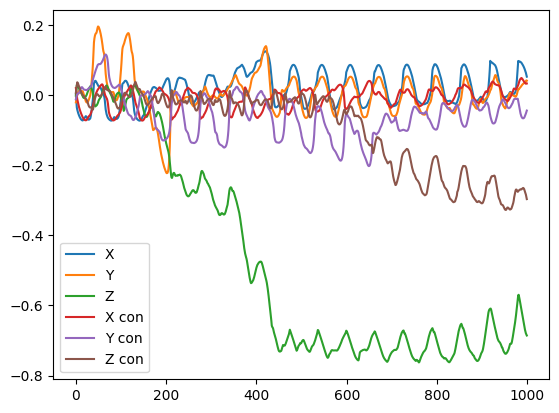

In [124]:
import matplotlib.pyplot as plt 
idx=0
plt.plot(textures[idx]['orientations'],label=["X","Y","Z"])
plt.plot(textures_control[idx]['orientations'],label=["X con","Y con","Z con"])
plt.legend()
plt.show()

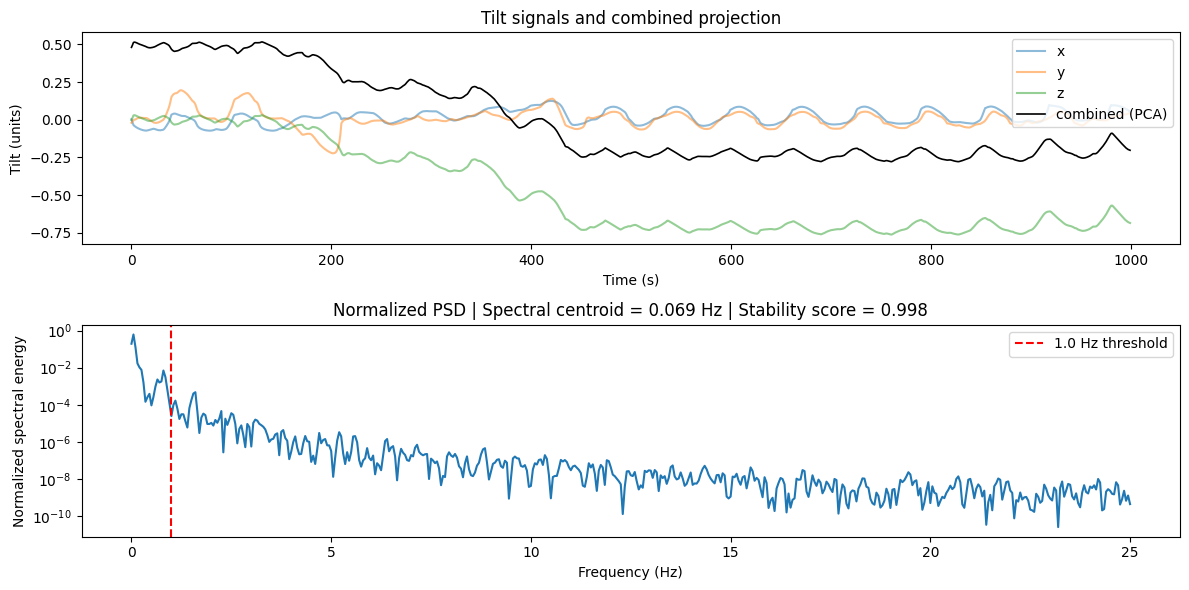

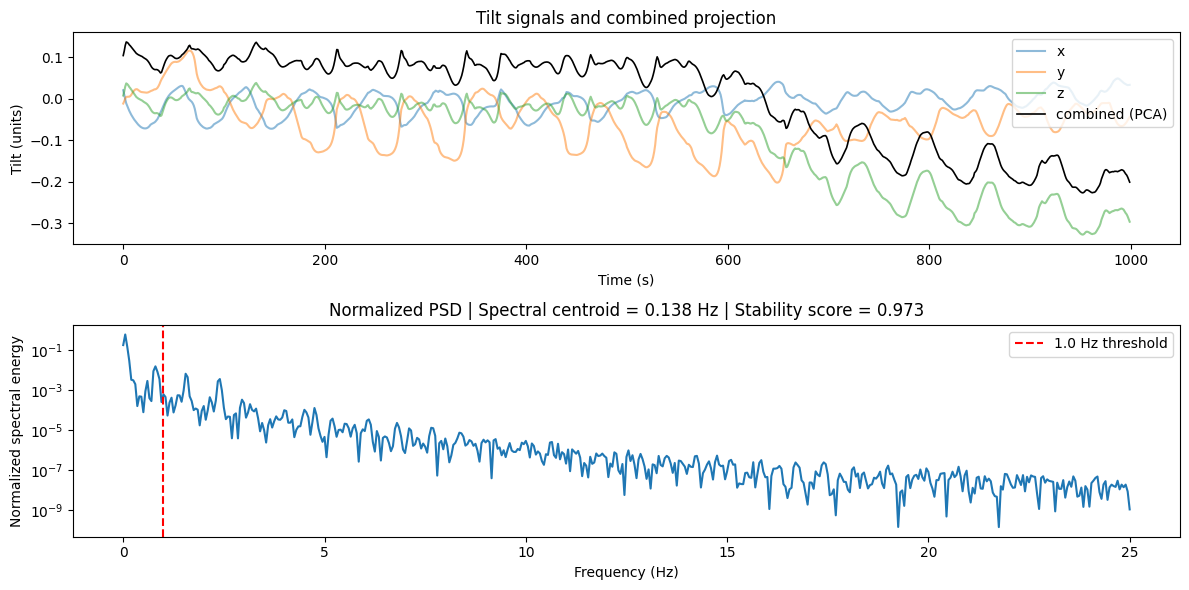

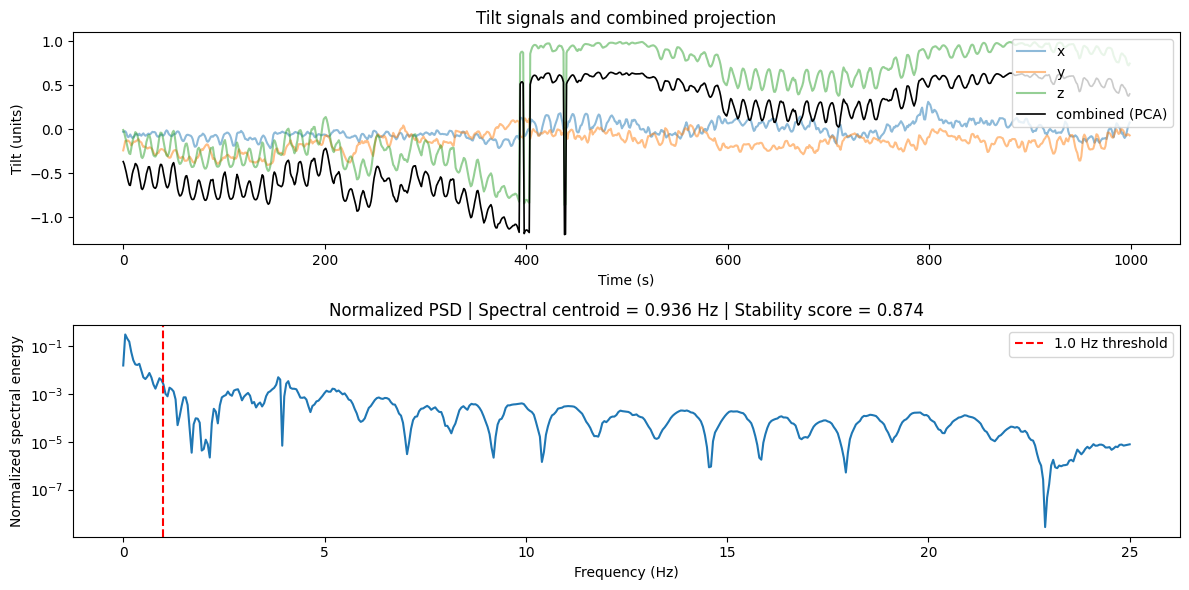

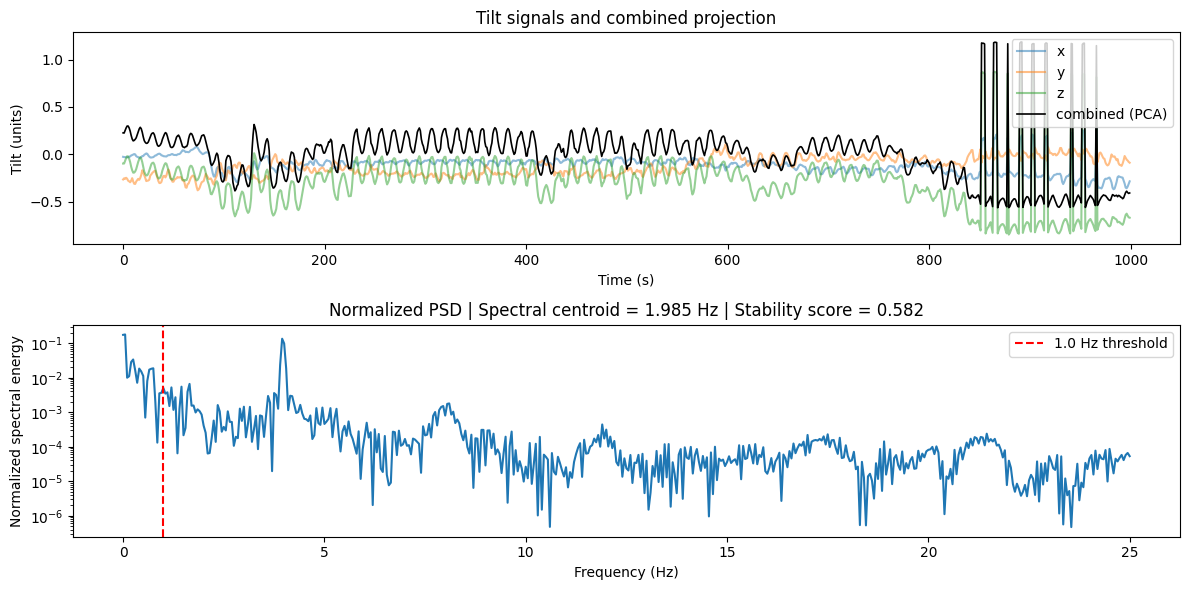

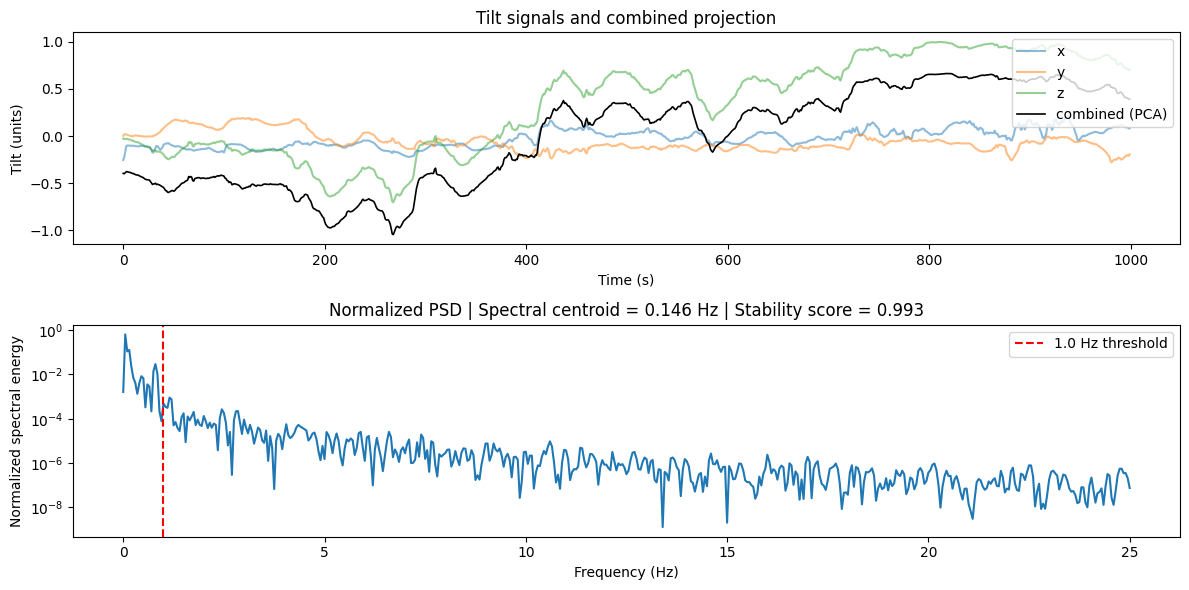

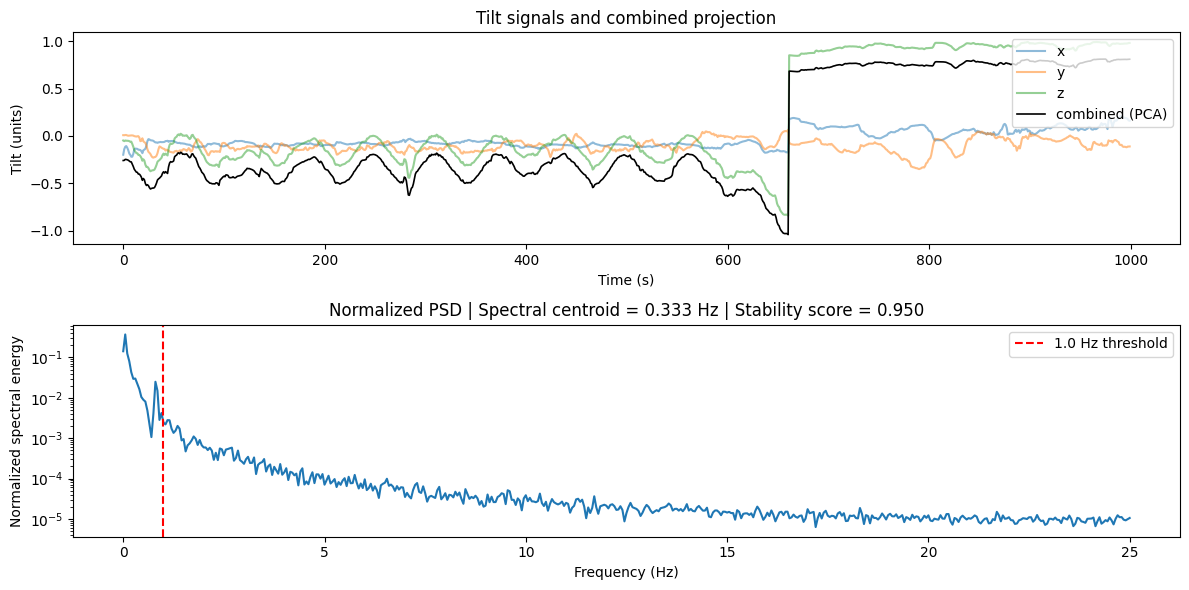

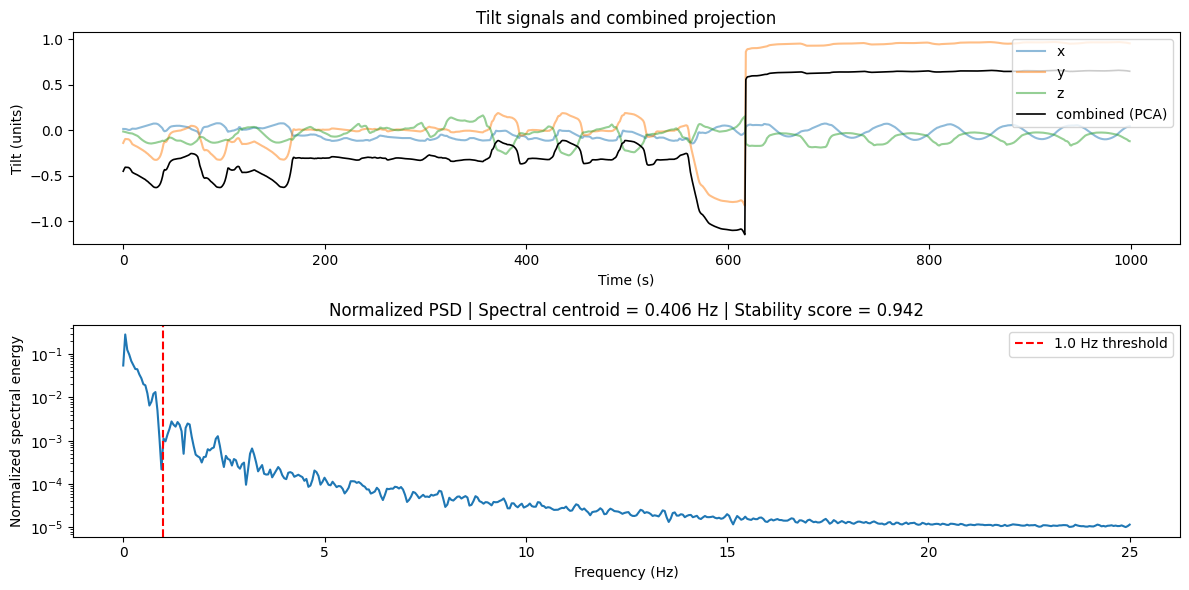

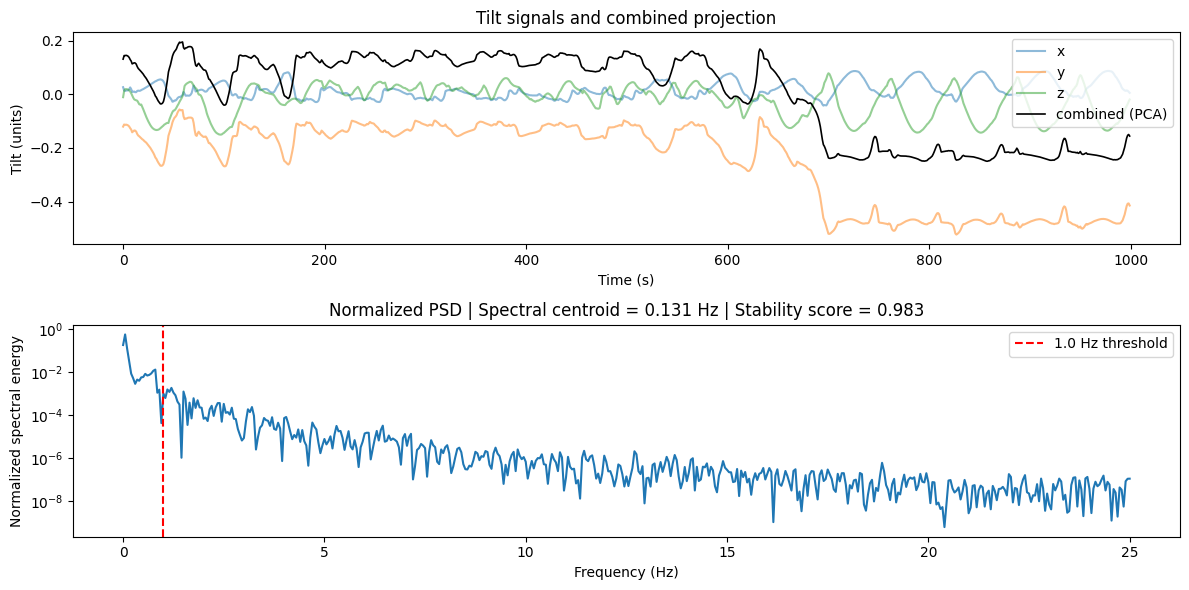

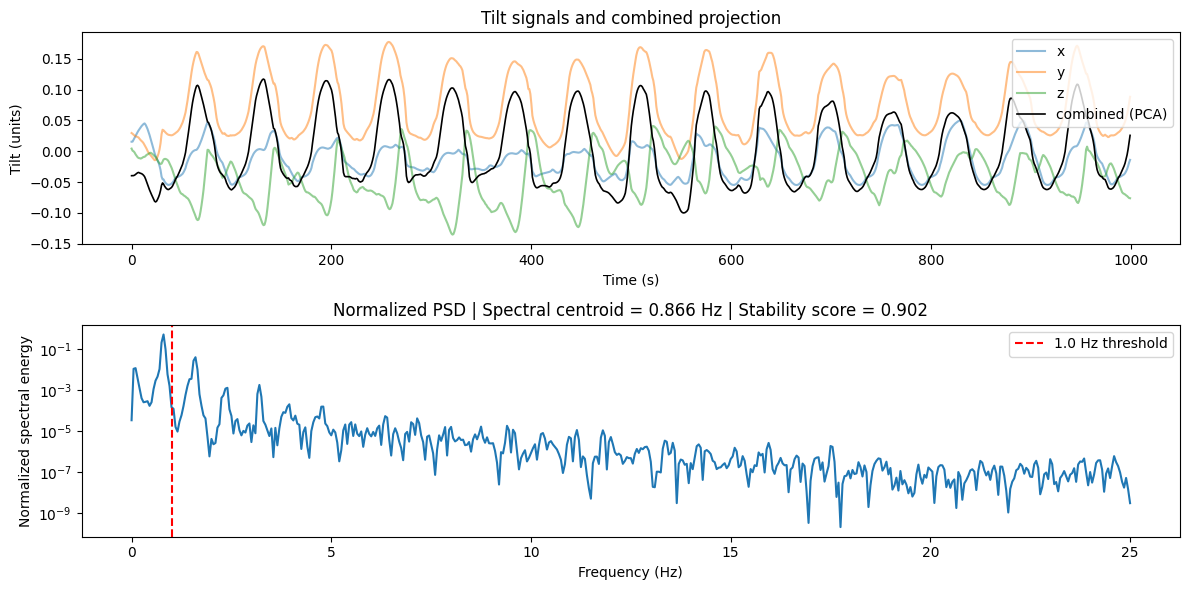

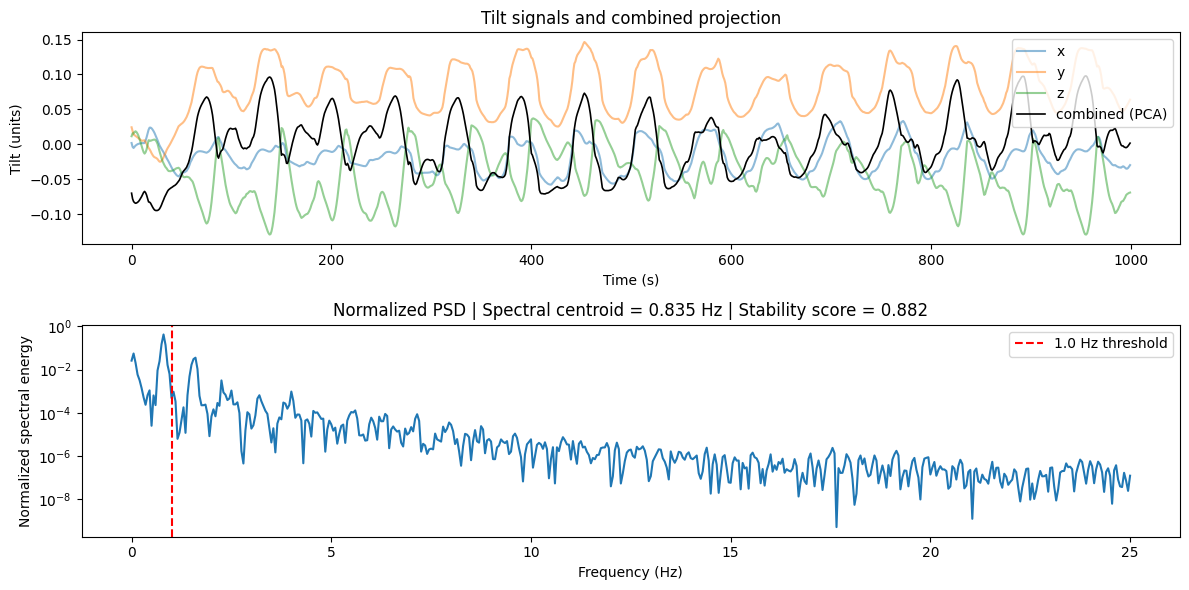

In [125]:
#fourier transform 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
def outputFourier(orientations):
    duration = len(orientations[:,0])
    t = np.arange(0, duration, 1)
    x=orientations[:,0]
    y=orientations[:,1]
    z=orientations[:,2]

    def combine_magnitude(x, y, z):
        return np.sqrt(x**2 + y**2 + z**2)

    def combine_pca(x, y, z, n_components=1):
        # stack and center
        X = np.vstack([x, y, z]).T
        pca = PCA(n_components=n_components)
        proj = pca.fit_transform(X)
        # returns first principal component time series (shape N,)
        return proj[:, 0], pca.explained_variance_ratio_

    sig_mag = combine_magnitude(x, y, z)
    sig_pca, pca_var = combine_pca(x, y, z)

    # choose one: sig = sig_mag or sig_pca
    sig = sig_pca  # pick PCA projection by default; change if you prefer magnitude

    # -------------------------
    # 2) Preprocess: detrend and apply window (optional)
    # -------------------------
    sig = sig - np.mean(sig)                # remove DC
    window = np.hanning(len(sig))
    sig_win = sig * window

    # -------------------------
    # 3) FFT and power spectrum
    # -------------------------
    N = len(sig_win)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    fft_vals = np.fft.rfft(sig_win)
    psd = (np.abs(fft_vals)**2) / (N**2)    # power spectral density (unnormalized)
    # alternatively scale so that sum(psd) == variance:
    psd = psd / np.sum(psd)                # normalized so total = 1 (useful for energy fractions)

    # spectral centroid (frequency-weighted)
    spectral_centroid = np.sum(freqs * psd)

    # -------------------------
    # 4) Stability metric
    #    Define "stable" as most energy below a threshold frequency f_thresh.
    #    Stability score = fraction of spectral energy below f_thresh (0..1).
    # -------------------------
    def stability_score(freqs, psd, f_thresh=1.0):
        mask = freqs <= f_thresh
        return np.sum(psd[mask])

    f_thresh = 1.0   # Hz, adjust to what you consider "low-frequency" / slow drift
    score = stability_score(freqs, psd, f_thresh=f_thresh)

    # -------------------------
    # 5) Plots: time series and spectrum
    # -------------------------
    plt.figure(figsize=(12,6))

    plt.subplot(2,1,1)
    plt.plot(t, x, label='x', alpha=0.5)
    plt.plot(t, y, label='y', alpha=0.5)
    plt.plot(t, z, label='z', alpha=0.5)
    plt.plot(t, sig, label='combined (PCA)', color='k', linewidth=1.2)
    plt.legend(loc='upper right')
    plt.title('Tilt signals and combined projection')
    plt.xlabel('Time (s)')
    plt.ylabel('Tilt (units)')

    plt.subplot(2,1,2)
    plt.semilogy(freqs, psd + 1e-12)   # semilog y for readability; add small offset so no log(0)
    plt.axvline(f_thresh, color='red', linestyle='--', label=f'{f_thresh} Hz threshold')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized spectral energy')
    plt.title(f'Normalized PSD | Spectral centroid = {spectral_centroid:.3f} Hz | Stability score = {score:.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()
for i in range(5):
    outputFourier(textures[i]['orientations'])
    outputFourier(textures_control[i]['orientations'])



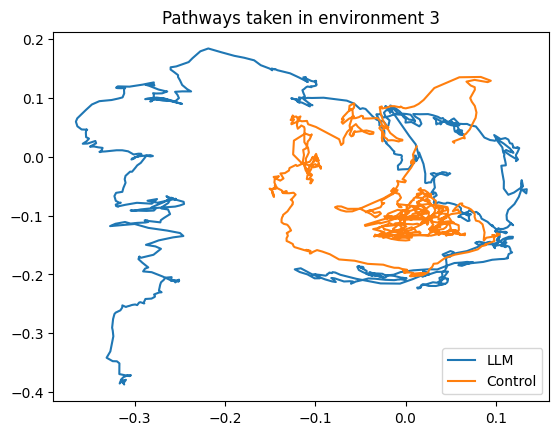

In [134]:
idx=2
plt.plot(textures[idx]['positions'][:,0],textures[idx]['positions'][:,1],label="LLM")
plt.plot(textures_control[idx]['positions'][:,0],textures_control[idx]['positions'][:,1],label="Control")
plt.legend()
plt.title("Pathways taken in environment "+str(idx+1))
plt.show()

In [127]:
lengths=[]
for i in range(6):
    l1=len(textures[i]['positions'])
    l2=len(textures_control[i]['positions'])
    lengths.append([l1,l2])

lengths=lengths
np.average(lengths,axis=0)

array([1000., 1000.])